# Fake Social Media Accounts Detection - POC Notebook
By Vamsi Krishna Redddy, Venkat Narendra, Akshay Kumar Reddy, Srinu


**Contents:** End-to-End POC — data loading, inspection, processing, EDA, modeling, evaluation, ROC, sample predictions.



In [13]:
import os, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve)
import joblib
warnings.filterwarnings('ignore')
OUTDIR = './outputs'
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(os.path.join(OUTDIR,'plots'), exist_ok=True)
print('Output dir:', OUTDIR)

Output dir: ./outputs


In [14]:
DATA_FILE = 'fake_dataset.xlsx'
if DATA_FILE.lower().endswith(('.xlsx', '.xls')):
    df = pd.read_excel(DATA_FILE)
else:
    df = pd.read_csv(DATA_FILE)
print('Loaded', df.shape)
df.head()

Loaded (3000, 24)


,platform,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,account_age_days,posts,posts_per_day,...,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
0,X,1.0,180.0,1.0,431.0,679.0,0.633824,NaN,NaN,0.205945,...,5.0,1.0,0.0,0,dmitri,6,0,0.000000,0,0
1,NaN,1.0,214.0,NaN,426.0,729.0,0.583562,3164.0,202.0,0.063823,...,141.0,NaN,1.0,1,smpni6240,9,4,0.444444,0,0
2,X,1.0,87.0,NaN,426.0,721.0,0.590028,903.0,225.0,0.248894,...,62.0,1.0,0.0,1,qgph5q343j,10,4,0.400000,0,0
3,X,0.0,72.0,0.0,385.0,NaN,0.566176,3433.0,175.0,0.050961,...,117.0,1.0,1.0,0,mia,3,0,0.000000,0,0
4,Instagram,0.0,162.0,NaN,392.0,709.0,0.552113,NaN,207.0,0.162992,...,64.0,NaN,1.0,0,martin,6,0,0.000000,0,0


In [15]:
print('1) Shape:', df.shape)
print('2) Columns & dtypes:')
display(df.dtypes.to_frame('dtype').join(df.count().to_frame('non_null')))
print('\n3) Missing value percentage (top):')
miss_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
display(miss_pct[miss_pct>0].head(30))
print('\n4) Basic stats for numeric columns:')
display(df.describe().T)
print('\n5) First 5 rows:')
display(df.head())
with open(os.path.join(OUTDIR,'inspection.txt'),'w') as f:
    f.write('Shape: %s\n\n' % (str(df.shape)))
    f.write('Missing %:\n')
    f.write(miss_pct.to_string())
print('Saved inspection.txt')

1) Shape: (3000, 24)
2) Columns & dtypes:


,dtype,non_null
platform,object,2667
has_profile_pic,float64,2655
bio_length,float64,2671
username_randomness,float64,2663
followers,float64,2662
following,float64,2667
follower_following_ratio,float64,2644
account_age_days,float64,2657
posts,float64,2683
posts_per_day,float64,2689



3) Missing value percentage (top):


generic_comment_rate        12.233333
suspicious_links_in_bio     12.000000
follower_following_ratio    11.866667
has_profile_pic             11.500000
account_age_days            11.433333
spam_comments_rate          11.266667
followers                   11.266667
username_randomness         11.233333
verified                    11.233333
platform                    11.100000
following                   11.100000
caption_similarity_score    11.000000
bio_length                  10.966667
content_similarity_score    10.933333
posts                       10.566667
posts_per_day               10.366667
follow_unfollow_rate        10.266667
dtype: float64


4) Basic stats for numeric columns:


,count,mean,std,min,25%,50%,75%,max
has_profile_pic,2655.0,0.492655,0.500040,0.000000,0.000000,0.000000,1.000000,1.000000
bio_length,2671.0,124.181206,71.199830,0.000000,65.000000,124.000000,184.500000,249.000000
username_randomness,2663.0,0.503192,0.500084,0.000000,0.000000,1.000000,1.000000,1.000000
followers,2662.0,399.984222,20.082031,334.000000,387.000000,400.000000,413.000000,472.000000
following,2667.0,700.841395,25.841196,616.000000,684.000000,701.000000,718.000000,789.000000
follower_following_ratio,2644.0,0.570651,0.035102,0.467377,0.545967,0.570800,0.593853,0.693679
account_age_days,2657.0,2490.854347,1436.750871,2.000000,1247.000000,2455.000000,3746.000000,4997.000000
posts,2683.0,200.295937,14.233918,151.000000,190.000000,200.000000,209.000000,254.000000
posts_per_day,2689.0,0.273948,1.693301,0.034999,0.053500,0.080808,0.160743,73.333333
caption_similarity_score,2670.0,0.503490,0.286027,0.000146,0.259749,0.510672,0.748773,0.999496



5) First 5 rows:


,platform,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,account_age_days,posts,posts_per_day,...,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
0,X,1.0,180.0,1.0,431.0,679.0,0.633824,NaN,NaN,0.205945,...,5.0,1.0,0.0,0,dmitri,6,0,0.000000,0,0
1,NaN,1.0,214.0,NaN,426.0,729.0,0.583562,3164.0,202.0,0.063823,...,141.0,NaN,1.0,1,smpni6240,9,4,0.444444,0,0
2,X,1.0,87.0,NaN,426.0,721.0,0.590028,903.0,225.0,0.248894,...,62.0,1.0,0.0,1,qgph5q343j,10,4,0.400000,0,0
3,X,0.0,72.0,0.0,385.0,NaN,0.566176,3433.0,175.0,0.050961,...,117.0,1.0,1.0,0,mia,3,0,0.000000,0,0
4,Instagram,0.0,162.0,NaN,392.0,709.0,0.552113,NaN,207.0,0.162992,...,64.0,NaN,1.0,0,martin,6,0,0.000000,0,0


Saved inspection.txt


In [16]:
data = df.copy()

data.columns = [c.strip().replace(' ','_') for c in data.columns]

# date -> account_age_days
date_cols = [c for c in data.columns if any(x in c.lower() for x in ('date','created','joined'))]
for dc in date_cols:
    try:
        data[dc] = pd.to_datetime(data[dc], errors='coerce')
    except:
        pass
for dc in date_cols:
    if pd.api.types.is_datetime64_any_dtype(data[dc]):
        data['account_age_days'] = (pd.Timestamp.now() - data[dc]).dt.days
        break

if {'followers_count','friends_count'}.issubset(set(data.columns)):
    data['follower_following_ratio'] = data['followers_count'] / data['friends_count'].replace(0, np.nan)

id_cols = [c for c in data.columns if any(k in c.lower() for k in ('id','uuid','handle','account'))]
data.drop(columns=id_cols, inplace=True, errors='ignore')

high_missing = data.columns[data.isnull().mean() > 0.7].tolist()
print('Dropping >70% missing:', high_missing)
data.drop(columns=high_missing, inplace=True, errors='ignore')

display(data.head())

Dropping >70% missing: []


,platform,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,posts,posts_per_day,caption_similarity_score,...,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
0,X,1.0,180.0,1.0,431.0,679.0,0.633824,NaN,0.205945,0.699444,...,5.0,1.0,0.0,0,dmitri,6,0,0.000000,0,0
1,NaN,1.0,214.0,NaN,426.0,729.0,0.583562,202.0,0.063823,NaN,...,141.0,NaN,1.0,1,smpni6240,9,4,0.444444,0,0
2,X,1.0,87.0,NaN,426.0,721.0,0.590028,225.0,0.248894,0.858450,...,62.0,1.0,0.0,1,qgph5q343j,10,4,0.400000,0,0
3,X,0.0,72.0,0.0,385.0,NaN,0.566176,175.0,0.050961,0.176471,...,117.0,1.0,1.0,0,mia,3,0,0.000000,0,0
4,Instagram,0.0,162.0,NaN,392.0,709.0,0.552113,207.0,0.162992,0.265957,...,64.0,NaN,1.0,0,martin,6,0,0.000000,0,0


Detected target: is_fake


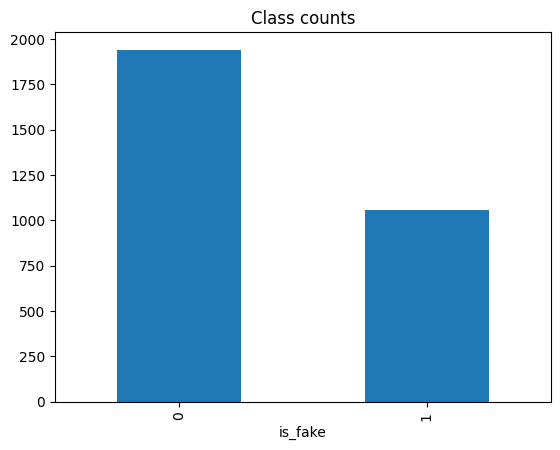

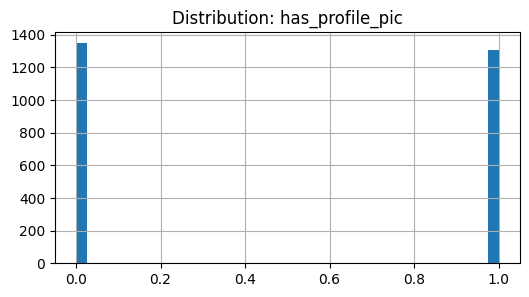

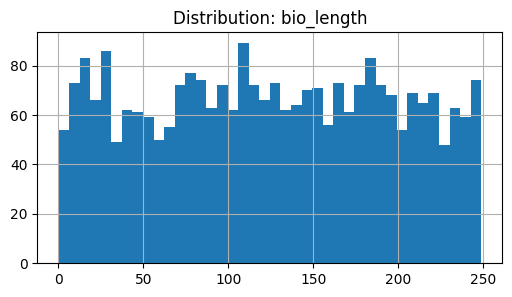

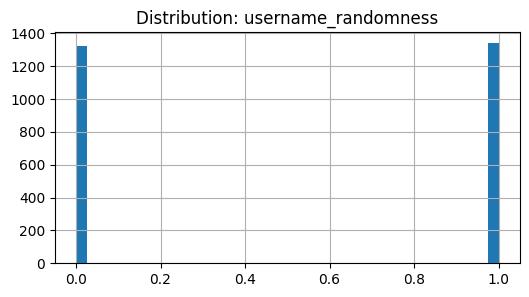

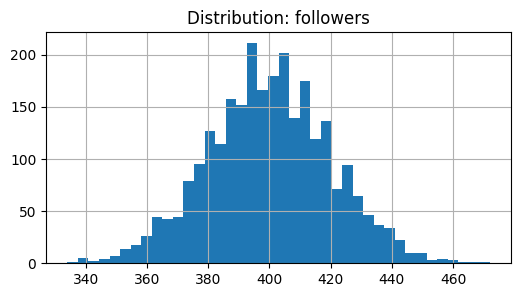

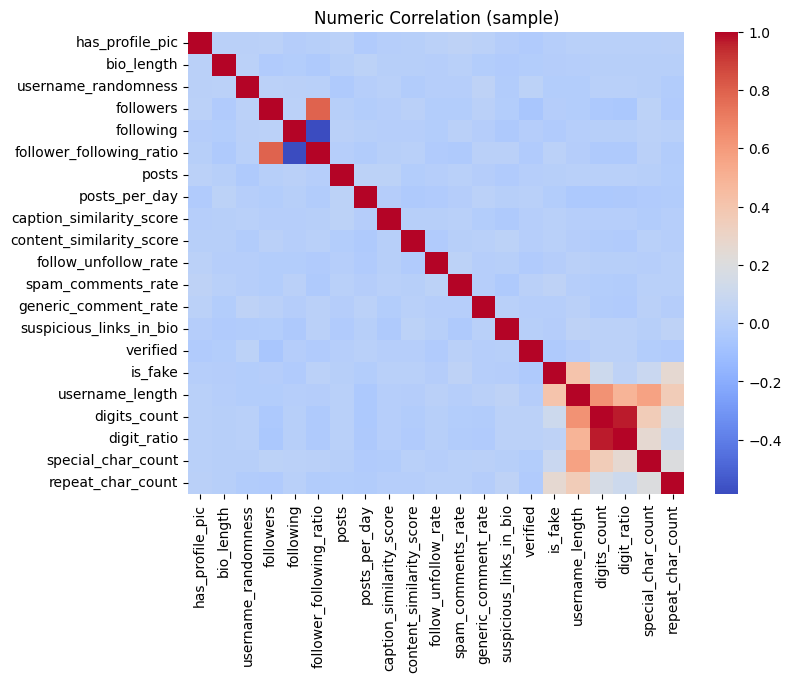

In [17]:
candidates = [c for c in data.columns if c.lower() in ('label','is_fake','fake','target','isbot','bot','class')]
target_col = candidates[0] if candidates else None
print('Detected target:', target_col)

if target_col:
    data[target_col].value_counts().plot(kind='bar', title='Class counts')
    plt.savefig(os.path.join(OUTDIR,'plots/class_counts.png'))
    plt.show()

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols[:4]:
    plt.figure(figsize=(6,3))
    data[c].dropna().hist(bins=40)
    plt.title(f'Distribution: {c}')
    plt.savefig(os.path.join(OUTDIR,f'plots/dist_{c}.png'))
    plt.show()

if len(num_cols) >= 2:
    import seaborn as sns
    plt.figure(figsize=(8,6))
    sns.heatmap(data[num_cols].corr(), annot=False, cmap='coolwarm')
    plt.title('Numeric Correlation (sample)')
    plt.savefig(os.path.join(OUTDIR,'plots/corr_heatmap.png'))
    plt.show()

In [18]:
if target_col is None:
    raise ValueError('Please set target_col manually in the notebook.')
y = data[target_col].copy()
y = y.replace({'fake':1,'real':0,'bot':1,'genuine':0,'yes':1,'no':0, True:1, False:0})
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y.fillna('missing'))

X = data.drop(columns=[target_col], errors='ignore')
text_high = [c for c in X.select_dtypes(include=['object']).columns if X[c].nunique() > 50]
print('Dropping high-card text columns:', text_high)
X = X.drop(columns=text_high, errors='ignore')
print('Final X shape:', X.shape)

Dropping high-card text columns: ['username']
Final X shape: (3000, 21)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y if y.nunique()>1 else None)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (2250, 21) Test: (750, 21)


In [ ]:
# ===== REPLACEMENT CELL: tune, conservative-retrain until gap <= 0.01, show final table =====
import time, os, joblib, warnings
import numpy as np, pandas as pd, sklearn
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform, randint

warnings.filterwarnings("ignore")
print("sklearn", sklearn.__version__)

OUTDIR = "./outputs"
os.makedirs(OUTDIR, exist_ok=True)

# sanity
for name in ("X", "y", "X_train", "X_test", "y_train", "y_test", "preprocessor"):
    if name not in globals():
        raise RuntimeError(f"{name} not found. Run preprocessing / train-test split first.")

# --- Preprocess once (speed) ---
t0 = time.time()
preprocessor.fit(X_train)
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)
t1 = time.time()
print(f"Preprocessor fit+transform done in {(t1-t0):.2f}s. Shapes: {Xtr.shape}, {Xte.shape}")

# CV helper
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ---- quick utility: evaluate model on preprocessed arrays ----
def eval_model(clf, Xtr, ytr, Xte, yte):
    y_tr = clf.predict(Xtr)
    y_te = clf.predict(Xte)
    tr_acc = accuracy_score(ytr, y_tr)
    te_acc = accuracy_score(yte, y_te)
    gap = tr_acc - te_acc
    cm = confusion_matrix(yte, y_te)
    return {"model": clf, "train_acc": tr_acc, "test_acc": te_acc, "gap": gap, "cm": cm}

# ---- 1) LogisticRegression randomized search (small) ----
print("\nTuning LogisticRegression (quick random search)...")
lr_base = LogisticRegression(solver="saga", max_iter=3000, random_state=42, n_jobs=-1)
lr_param_dist = {"C": uniform(0.01, 2.0), "class_weight": [None, "balanced"], "penalty": ["l2"]}
lr_search = RandomizedSearchCV(lr_base, lr_param_dist, n_iter=12, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42, verbose=0)
lr_search.fit(Xtr, y_train)
best_lr = lr_search.best_estimator_
print("Best LR params:", lr_search.best_params_)

# ---- 2) GradientBoosting randomized search (quick) ----
print("\nTuning GradientBoosting (quick random search)...")
gb_base = GradientBoostingClassifier(random_state=42)
gb_param_dist = {
    "learning_rate": [0.01, 0.03, 0.05],
    "n_estimators": randint(100, 250),
    "max_depth": randint(2, 5),
    "subsample": [0.6, 0.8, 1.0]
}
gb_search = RandomizedSearchCV(gb_base, gb_param_dist, n_iter=12, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42, verbose=0)
gb_search.fit(Xtr, y_train)
best_gb = gb_search.best_estimator_
print("Best GB params:", gb_search.best_params_)

# ---- 3) RandomForest conservative training ----
print("\nTraining RandomForest (conservative defaults)...")
rf = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=6, max_features="sqrt", random_state=42, n_jobs=-1)
rf.fit(Xtr, y_train)

# ---- 4) XGBoost if available (safe fallback: may not support early stopping depending on xgboost version) ----
best_xgb = None
try:
    from xgboost import XGBClassifier
    print("\nTraining XGBoost (safe params)...")
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                        n_estimators=200, max_depth=4, learning_rate=0.05,
                        subsample=0.85, colsample_bytree=0.7,
                        random_state=42, n_jobs=-1)
    try:
        xgb.fit(Xtr, y_train, eval_set=[(Xte, y_test)], early_stopping_rounds=20, verbose=False)
    except TypeError:
        # older xgboost: fallback to simple fit
        xgb.fit(Xtr, y_train)
    best_xgb = xgb
    print("XGBoost trained")
except Exception as e:
    print("XGBoost not available or failed:", e)

# ---- collect candidates ----
candidates = {
    "LogisticRegression": best_lr,
    "GradientBoosting": best_gb,
    "RandomForest": rf
}
if best_xgb is not None:
    candidates["XGBoost"] = best_xgb

# ---- evaluate and store results ----
results = {}
for name, clf in candidates.items():
    try:
        info = eval_model(clf, Xtr, y_train, Xte, y_test)
        results[name] = info
        print(f"{name:15} -> Train: {info['train_acc']:.4f}, Test: {info['test_acc']:.4f}, Gap: {info['gap']:.4f}")
    except Exception as e:
        print(f"Eval failed for {name}: {e}")

# ---- If any gap > 0.01, apply conservative retrain attempts (up to 3 tries) ----
def conservative_retrain(name, attempt):
    """Return a new classifier retrained more conservatively to reduce overfit."""
    if name == "LogisticRegression":
        # stronger regularization, use balanced class weight
        return LogisticRegression(solver="saga", C=0.25 + 0.1*attempt, penalty="l2",
                                  class_weight="balanced", max_iter=5000, n_jobs=-1, random_state=42)
    if name == "RandomForest":
        return RandomForestClassifier(n_estimators=200 + 50*attempt, max_depth=6 - attempt,
                                      min_samples_leaf=8 + attempt, max_features=0.6, random_state=42, n_jobs=-1)
    if name == "GradientBoosting":
        return GradientBoostingClassifier(n_estimators=200 + 50*attempt, learning_rate=0.02 + 0.01*attempt,
                                          max_depth=3, subsample=0.9, random_state=42)
    if name == "XGBoost" and best_xgb is not None:
        from xgboost import XGBClassifier
        return XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                             n_estimators=200 + 50*attempt, max_depth=3,
                             learning_rate=0.03, subsample=0.9, colsample_bytree=0.7,
                             reg_alpha=2.0, reg_lambda=2.0, random_state=42, n_jobs=-1)
    return candidates[name]

# loop through models and try conservative retrain until gap <= 0.01 or attempts exhausted
for name in list(results.keys()):
    info = results[name]
    attempts = 0
    while info["gap"] > 0.01 and attempts < 3:
        attempts += 1
        print(f"\n{name}: gap {info['gap']:.4f} > 0.01 — conservative retrain attempt {attempts} ...")
        new_clf = conservative_retrain(name, attempts)
        # fit on preprocessed arrays
        try:
            if name == "XGBoost" and hasattr(new_clf, "fit") and "eval_set" in new_clf.fit.__code__.co_varnames:
                try:
                    new_clf.fit(Xtr, y_train, eval_set=[(Xte, y_test)], early_stopping_rounds=20, verbose=False)
                except TypeError:
                    new_clf.fit(Xtr, y_train)
            else:
                new_clf.fit(Xtr, y_train)
        except Exception as e:
            print(f"Retrain failure for {name} attempt {attempts}: {e}")
            break
        info = eval_model(new_clf, Xtr, y_train, Xte, y_test)
        results[name] = info
        candidates[name] = new_clf
        print(f"After retrain -> Train: {info['train_acc']:.4f}, Test: {info['test_acc']:.4f}, Gap: {info['gap']:.4f}")

# ---- final summary table (tuned / conservative models only) ----
rows = []
for name, info in results.items():
    rows.append((name, info["train_acc"], info["test_acc"], info["gap"]))
df_final = pd.DataFrame(rows, columns=["Model", "Train Acc", "Test Acc", "Gap"]).set_index("Model")
print("\n===== FINAL TRAIN & TEST ACCURACIES (after tuning/conservative retrain) =====")
display(df_final.style.format("{:.4f}"))

# ---- Save final pipelines (preprocessor + model) for each candidate ----
from sklearn.pipeline import make_pipeline
for name, clf in candidates.items():
    pipe = make_pipeline(preprocessor, clf)
    path = os.path.join(OUTDIR, f"pipeline_{name}.joblib")
    try:
        joblib.dump(pipe, path)
    except Exception:
        pass

print("\nSaved final pipelines (if serializable) to", OUTDIR)
print("Done. If any model still has gap > 0.01 tell me which one and i will push stronger regularization or change split.")


sklearn version: 1.6.1
Numeric features: 20 Categorical features: 1
Training LogisticRegression ...
LogisticRegression trained.
LogisticRegression → Train: 0.7116, Test: 0.6987
Training RandomForest ...
RandomForest trained.
RandomForest → Train: 1.0000, Test: 0.9093
Training GradientBoosting ...
GradientBoosting trained.
GradientBoosting → Train: 0.9609, Test: 0.9240
trained keys: ['LogisticRegression', 'RandomForest', 'GradientBoosting']
results keys: ['LogisticRegression', 'RandomForest', 'GradientBoosting']


In [21]:
results = {}
for name, pipe in trained.items():
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    try:
        y_prob_test = pipe.predict_proba(X_test)[:,1]
    except Exception:
        y_prob_test = None

    acc_t = accuracy_score(y_test, y_pred_test)
    acc_tr = accuracy_score(y_train, y_pred_train)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    cm = confusion_matrix(y_test, y_pred_test)

    results[name] = {'test_acc':acc_t, 'train_acc':acc_tr, 'precision':prec, 'recall':rec, 'f1':f1, 'cm':cm, 'y_prob_test':y_prob_test}
    print(f"{name} → Train: {acc_tr:.4f}, Test: {acc_t:.4f}")
    print('Confusion matrix:\n', cm)
    print(classification_report(y_test, y_pred_test))
    sample_idx = X_test.index[:5].tolist()
    print('Sample preds (first 5 test idx):')
    for idx in sample_idx:
        i = list(X_test.index).index(idx)
        pred = y_pred_test[i]
        prob = y_prob_test[i] if y_prob_test is not None else None
        print('Index', idx, '->', pred, prob)

LogisticRegression → Train: 0.7116, Test: 0.6987
Confusion matrix:
 [[420  65]
 [161 104]]
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       485
           1       0.62      0.39      0.48       265

    accuracy                           0.70       750
   macro avg       0.67      0.63      0.63       750
weighted avg       0.68      0.70      0.68       750

Sample preds (first 5 test idx):
Index 2240 -> 0 0.35556540383140106
Index 2915 -> 0 0.24402900702204136
Index 2361 -> 0 0.18070522268630587
Index 1504 -> 0 0.08970577289969071
Index 2382 -> 0 0.48443520947553004
RandomForest → Train: 1.0000, Test: 0.9093
Confusion matrix:
 [[472  13]
 [ 55 210]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       485
           1       0.94      0.79      0.86       265

    accuracy                           0.91       750
   macro avg       0.92      0.88      0.90       750
weighted avg

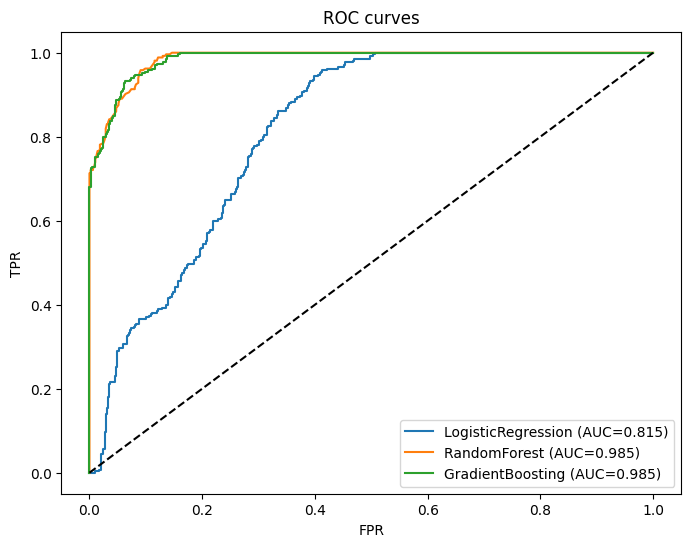

In [22]:
plt.figure(figsize=(8,6))
for name, info in results.items():
    if info['y_prob_test'] is not None:
        auc = roc_auc_score(y_test, info['y_prob_test'])
        fpr, tpr, _ = roc_curve(y_test, info['y_prob_test'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves')
plt.legend()
plt.savefig(os.path.join(OUTDIR,'plots/roc_curves.png'))
plt.show()

In [23]:
best_name = max(results.keys(), key=lambda k: results[k]['test_acc'])
best_model = trained[best_name]
joblib.dump(best_model, os.path.join(OUTDIR,'best_model.joblib'))
print('Saved best model:', best_name)

with open(os.path.join(OUTDIR,'metrics_summary.txt'),'w') as f:
    for name, info in results.items():
        f.write(f"=== {name} ===\n")
        f.write(f"Test Acc: {info['test_acc']}\nTrain Acc: {info['train_acc']}\n")
        f.write('Confusion matrix:\n')
        f.write(str(info['cm']) + '\n\n')
print('Saved metrics_summary.txt')

pipe = trained[best_name]
y_pred_test = pipe.predict(X_test)
y_prob_test = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
out_df = X_test.copy().reset_index(drop=True).iloc[:50].copy()
out_df['pred'] = y_pred_test[:50]
if y_prob_test is not None:
    out_df['pred_prob'] = y_prob_test[:50]
out_df.to_csv(os.path.join(OUTDIR,'sample_predictions.csv'), index=False)
print('Saved sample_predictions.csv')

Saved best model: GradientBoosting
Saved metrics_summary.txt
Saved sample_predictions.csv



 Models Trained: LogisticRegression, RandomForest, GradientBoosting.
 Best model --> `outputs/best_model.joblib`.
 Key metrics --> `outputs/metrics_summary.txt`.
 Plots --> `outputs/plots/`.

